In [1]:
# importing all necessary packages
import gluonbook as gb
import mxnet as mx
from mxnet import gluon, init, nd, autograd
from mxnet.gluon import nn


In [2]:
def convBlock(nChannels):
    denseNet = nn.Sequential()
    #print("denseNet in convBlock: ", denseNet)
    denseNet.add(nn.BatchNorm(),nn.Activation('relu'),nn.Conv2D(nChannels, kernel_size=3, padding=1))
    return denseNet

In [3]:
class DenseBlock(nn.Block):
    def __init__(self, nConvs, nChannels, **kwargs):
        super(DenseBlock, self).__init__(**kwargs)
        self.net = nn.Sequential()
        
        for _ in range(nConvs):
            self.net.add(convBlock(nChannels))
            #print("Self net:", self.net)
    def forward(self, X):
        for block in self.net:
            Y = block(X)
            X = nd.concat(X, Y, dim=1) # Concatenate the input and output of each block on the channel dimension.
        return X

In [4]:
# transition layer - used to control the complexity of the model. 
#                  - Reduces the number of channels by using the 1x1 convolutional layer and halves the height 
#                    and width of the average pooling layer with a stride of 2
def transBlock(nChannels):
    transblk = nn.Sequential()
    transblk.add(nn.BatchNorm(), nn.Activation('relu'),
            nn.Conv2D(nChannels, kernel_size=1),
            nn.AvgPool2D(pool_size=2, strides=2))
    return transblk



In [5]:
def data_xform(data):
    """Move channel axis to the beginning, cast to float32, and normalize to [0, 1]."""
    return nd.moveaxis(data, 2, 0).astype('float32') / 255

In [6]:
def build_denseNet(denseblk):
    denseblk = DenseBlock(2, 10)
    denseblk.initialize()
    denseblk = transBlock(10)
    denseblk.initialize()
    denseblk = nn.Sequential()
    denseblk.add(nn.Conv2D(64, kernel_size=5, strides=2, padding=3),
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))
    num_channels, growth_rate = 64, 32
    num_convs_in_dense_blocks = [4, 4, 4, 4]
    
    for i, num_convs in enumerate(num_convs_in_dense_blocks):
        denseblk.add(DenseBlock(num_convs, growth_rate))
        # This is the number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added between the dense blocks
        if i != len(num_convs_in_dense_blocks) - 1:
            denseblk.add(transBlock(num_channels // 2))
    denseblk.add(nn.BatchNorm(),nn.Activation('relu'),nn.GlobalAvgPool2D(), nn.Dense(10))
    return(denseblk)

In [7]:
denseblk = build_denseNet(gluon.nn.Sequential())

train_data = mx.gluon.data.vision.MNIST(train=True).transform_first(data_xform)
val_data = mx.gluon.data.vision.MNIST(train=False).transform_first(data_xform)

batch_size = 256
train_iter = mx.gluon.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_iter = mx.gluon.data.DataLoader(val_data, shuffle=False, batch_size=batch_size)

lr, num_epochs, ctx = 0.1, 5, gb.try_gpu()
denseblk.initialize(ctx=ctx, init=init.Xavier())
trainer = gluon.Trainer(denseblk.collect_params(), 'sgd', {'learning_rate': lr})
gb.train_ch5(denseblk, train_iter, test_iter, batch_size, trainer, ctx, num_epochs)

training on cpu(0)
epoch 1, loss 0.1257, train acc 0.962, test acc 0.981, time 322.4 sec
epoch 2, loss 0.0336, train acc 0.990, test acc 0.977, time 329.3 sec
epoch 3, loss 0.0224, train acc 0.993, test acc 0.988, time 321.1 sec
epoch 4, loss 0.0154, train acc 0.996, test acc 0.991, time 323.9 sec
epoch 5, loss 0.0102, train acc 0.997, test acc 0.990, time 325.3 sec


In [9]:
file_name = "densenet_mnist.params"
denseblk.save_parameters(file_name)

In [10]:
new_net = build_denseNet(gluon.nn.Sequential())
new_net.load_parameters(file_name, ctx=ctx)

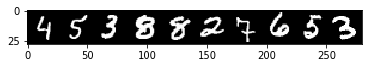

Model predictions:  [4. 5. 3. 8. 8. 2. 7. 6. 5. 3.]


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def verify_loaded_model(net):
    """Run inference using ten random images.
    Print both input and output of the model"""

    def transform(data, label):
        return data.astype(np.float32)/255, label.astype(np.float32)

    # Load ten random images from the test dataset
    sample_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                                  10, shuffle=True)

    for data, label in sample_data:

        # Display the images
        img = nd.transpose(data, (1,0,2,3))
        img = nd.reshape(img, (28,10*28,1))
        imtiles = nd.tile(img, (1,1,3))
        plt.imshow(imtiles.asnumpy())
        plt.show()

        # Display the predictions
        data = nd.transpose(data, (0, 3, 1, 2))
        out = net(data.as_in_context(ctx))
        predictions = nd.argmax(out, axis=1)
        print('Model predictions: ', predictions.asnumpy())

        break

verify_loaded_model(new_net)